In [80]:
import numpy as N
import matplotlib.pyplot as P
import matplotlib
from skimage.measure import find_contours
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.integrate as spi
import h5py

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Import my figure routines
import sys
sys.path.append('../')
sys.path.append('../transformations/')
from figure_module import *


In [81]:
# Parameters
cfl = 0.5
Nx = 64 # Number of cells
Nx_int = Nx + 1 # Number of integer points
Nx_half = Nx + 2 # NUmber of hlaf-step points
Ny = 64 # Number of cells
Ny_int = Ny + 1 # Number of integer points
Ny_half = Ny + 2 # NUmber of hlaf-step points

x_min, x_max = - 0.5, 0.5
dx = (x_max - x_min) / Nx
y_min, y_max = - 0.5, 0.5
dy = (y_max - y_min) / Ny

dt = cfl / N.sqrt(1.0 / dx**2 + 1.0 / dy**2)

In [82]:
# Define grids
x_int  = N.linspace(x_min, x_max, Nx_int)
x_half  = N.zeros(Nx_half)
x_half[0] = x_int[0]
x_half[-1] = x_int[-1]
x_half[1:-1] = x_int[:-1] + 0.5 * dx

y_int  = N.linspace(y_min, y_max, Ny_int)
y_half  = N.zeros(Ny_half)
y_half[0] = y_int[0]
y_half[-1] = y_int[-1]
y_half[1:-1] = y_int[:-1] + 0.5 * dy

yBz_grid, xBz_grid = N.meshgrid(y_half, x_half)
yEx_grid, xEx_grid = N.meshgrid(y_int, x_half)
yEy_grid, xEy_grid = N.meshgrid(y_half, x_int)
yEz_grid, xEz_grid = N.meshgrid(y_int, x_int)

n_patches = 1

# Define fields

Bx = N.zeros((n_patches, Nx_int, Ny_half))
By = N.zeros((n_patches, Ny_half, Ny_int))
Bz = N.zeros((n_patches, Nx_half, Ny_half))
Ex = N.zeros((n_patches, Nx_half, Ny_int))
Ey = N.zeros((n_patches, Nx_int, Ny_half))
Ez = N.zeros((n_patches, Nx_int, Ny_int))
Jx = N.zeros((n_patches, Nx_half, Ny_int))
Jy = N.zeros((n_patches, Nx_int, Ny_half))
Jz = N.zeros((n_patches, Nx_int, Ny_int))
rho = N.zeros((n_patches, Nx_int, Ny_int))

dBxdx = N.zeros((n_patches, Nx_half, Ny_half))
dBxdy = N.zeros((n_patches, Nx_int, Ny_int))
dBxdz = N.zeros((n_patches, Nx_int, Ny_half))
dBydx = N.zeros((n_patches, Nx_int, Ny_int))
dBydy = N.zeros((n_patches, Nx_half, Ny_half))
dBydz = N.zeros((n_patches, Nx_half, Ny_int))
dBzdx = N.zeros((n_patches, Nx_int, Ny_half))
dBzdy = N.zeros((n_patches, Nx_half, Ny_int))
dBzdz = N.zeros((n_patches, Nx_half, Ny_half))

dExdx = N.zeros((n_patches, Nx_int, Ny_int))
dExdy = N.zeros((n_patches, Nx_half, Ny_half))
dExdz = N.zeros((n_patches, Nx_half, Ny_int))
dEydx = N.zeros((n_patches, Nx_half, Ny_half))
dEydy = N.zeros((n_patches, Nx_int, Ny_int))
dEydz = N.zeros((n_patches, Nx_int, Ny_half))
dEzdx = N.zeros((n_patches, Nx_half, Ny_int))
dEzdy = N.zeros((n_patches, Nx_int, Ny_half))
dEzdz = N.zeros((n_patches, Nx_int, Ny_int))

Bx_save = N.zeros((n_patches, Nx_int, Ny_half))
By_save = N.zeros((n_patches, Ny_half, Ny_int))
Bz_save = N.zeros((n_patches, Nx_half, Ny_half))
Ex_save = N.zeros((n_patches, Nx_half, Ny_int))
Ey_save = N.zeros((n_patches, Nx_int, Ny_half))
Ez_save = N.zeros((n_patches, Nx_int, Ny_int))

k1_Bx = N.zeros((Nx_int, Ny_half))
k1_By = N.zeros((Ny_half, Ny_int))
k1_Bz = N.zeros((Nx_half, Ny_half))
k1_Ex = N.zeros((Nx_half, Ny_int))
k1_Ey = N.zeros((Nx_int, Ny_half))
k1_Ez = N.zeros((Nx_int, Ny_int))

k2_Bx = N.zeros((Nx_int, Ny_half))
k2_By = N.zeros((Ny_half, Ny_int))
k2_Bz = N.zeros((Nx_half, Ny_half))
k2_Ex = N.zeros((Nx_half, Ny_int))
k2_Ey = N.zeros((Nx_int, Ny_half))
k2_Ez = N.zeros((Nx_int, Ny_int))

k3_Bx = N.zeros((Nx_int, Ny_half))
k3_By = N.zeros((Ny_half, Ny_int))
k3_Bz = N.zeros((Nx_half, Ny_half))
k3_Ex = N.zeros((Nx_half, Ny_int))
k3_Ey = N.zeros((Nx_int, Ny_half))
k3_Ez = N.zeros((Nx_int, Ny_int))

k4_Bx = N.zeros((Nx_int, Ny_half))
k4_By = N.zeros((Ny_half, Ny_int))
k4_Bz = N.zeros((Nx_half, Ny_half))
k4_Ex = N.zeros((Nx_half, Ny_int))
k4_Ey = N.zeros((Nx_int, Ny_half))
k4_Ez = N.zeros((Nx_int, Ny_int))

PBx = N.zeros((n_patches, Nx_int, Ny_half))
PBy = N.zeros((n_patches, Ny_half, Ny_int))
PBz = N.zeros((n_patches, Nx_half, Ny_half))
PEx = N.zeros((n_patches, Nx_half, Ny_int))
PEy = N.zeros((n_patches, Nx_int, Ny_half))
PEz = N.zeros((n_patches, Nx_int, Ny_int))


In [83]:
def tiltclock(array_in):
    return N.transpose(N.flip(array_in, axis = 0))

def tiltanticlock(array_in):
    return N.flip(N.transpose(array_in), axis = 0)

def intint2halfint(array_in):
    
    array_out = N.zeros((Nx_half, Ny_int))
    
    array_out[0, :] = array_in[0, :]
    array_out[Nx_half - 1, :] = array_in[Nx_int - 1, :]
    array_out[1:(Nx_half - 1), :] = (array_in + N.roll(array_in, -1, axis = 0))[0:(Nx_int - 1), :] / 2.0
    
    return array_out
    
def halfint2intint(array_in):
    
    array_out = N.zeros((Nx_int, Ny_int))
    
    array_out[0, :] = array_in[0, :]
    array_out[Nx_int - 1, :] = array_in[Nx_half - 1, :]
    array_out[1:(Nx_int - 1), :] = (array_in + N.roll(array_in, -1, axis = 0))[1:(Nx_half - 2), :] / 2.0
    
    return array_out

def intint2inthalf(array_in):
    
    array_out = N.zeros((Nx_int, Ny_half))
    
    array_out[:, :] = tiltanticlock(intint2halfint(tiltclock(array_in)))
    
    return array_out

def inthalf2intint(array_in):
    
    array_out = N.zeros((Nx_int, Ny_int))
    
    array_out[:, :] = tiltanticlock(halfint2intint(tiltclock(array_in)))
    
    return array_out

def halfhalf2halfint(array_in):
    
    array_out = N.zeros((Nx_half, Ny_int))
    
    array_out[:, 0] = array_in[:, 0]
    array_out[:, Ny_int - 1] = array_in[:, Ny_half - 1]
    array_out[:, 1:(Ny_int - 1)] = (array_in + N.roll(array_in, -1, axis = 1))[:, 1:(Ny_half - 2)] / 2.0
    
    return array_out

def halfint2halfhalf(array_in):
    
    array_out = N.zeros((Nx_half, Ny_half))
    
    array_out[:, 0] = array_in[:, 0]
    array_out[:, Ny_half - 1] = array_in[:, Ny_int - 1]
    array_out[:, 1:(Ny_half - 1)] = (array_in + N.roll(array_in, -1, axis = 1))[:, 0:(Ny_int - 1)] / 2.0
    
    return array_out

def halfhalf2inthalf(array_in):
    
    array_out = N.zeros((Nx_int, Ny_half))
    
    array_out[:, :] = tiltanticlock(halfhalf2halfint(tiltclock(array_in)))

    return array_out

def inthalf2halfhalf(array_in):
    
    array_out = N.zeros((Nx_half, Ny_half))

    array_out[:, :] = tiltanticlock(halfint2halfhalf(tiltclock(array_in)))

    return array_out

def intint2halfhalf(array_in):
    
    array_out = N.zeros((Nx_half, Ny_half))
    
    array_out[:, :] = inthalf2halfhalf(intint2inthalf(array_in))
    
    return array_out

def halfhalf2intint(array_in):
    
    array_out = N.zeros((Nx_int, Ny_int))
    
    array_out[:, :] = inthalf2intint(halfhalf2inthalf(array_in))
    
    return array_out

def halfint2inthalf(array_in):
    
    array_out = N.zeros((Nx_int, Ny_half))
    
    array_out[:, :] = intint2inthalf(halfint2intint(array_in))
    
    return array_out

def inthalf2halfint(array_in):
    
    array_out = N.zeros((Nx_half, Ny_int))
    
    array_out[:, :] = intint2halfint(inthalf2intint(array_in))
    
    return array_out

def halfint2halfint(array_in):
    return array_in

def inthalf2inthalf(array_in):
    return array_in

def halfhalf2halfhalf(array_in):
    return array_in

def intint2intint(array_in):
    return array_in


In [84]:
driver_eb = 0

########
# SBP operators
########

P_int_2 = N.ones(Nx_int)
P_int_2[0] = 0.5 
P_int_2[-1] = 0.5 

P_half_2 = N.ones(Nx_half)
P_half_2[0] = 0.5 
P_half_2[1] = 0.25 
P_half_2[2] = 1.25 
P_half_2[-3] = 1.25 
P_half_2[-2] = 0.25 
P_half_2[-1] = 0.5 

def compute_diff_B(p, Bxin, Byin, Bzin):

    dBzdx[p, 0, :] = (- 0.5 * Bzin[p, 0, :] + 0.25 * Bzin[p, 1, :] + 0.25 * Bzin[p, 2, :]) / dx / P_int_2[0]
    dBzdx[p, 1, :] = (- 0.5 * Bzin[p, 0, :] - 0.25 * Bzin[p, 1, :] + 0.75 * Bzin[p, 2, :]) / dx / P_int_2[1]
    dBzdx[p, Nx_int - 2, :] = (- 0.75 * Bzin[p, -3, :] + 0.25 * Bzin[p, -2, :] + 0.5 * Bzin[p, -1, :]) / dx / P_int_2[Nx_int - 2]
    dBzdx[p, Nx_int - 1, :] = (- 0.25 * Bzin[p, -3, :] - 0.25 * Bzin[p, -2, :] + 0.5 * Bzin[p, -1, :]) / dx / P_int_2[Nx_int - 1]
    dBzdx[p, 2:(Nx_int - 2), :] = (N.roll(Bzin, -1, axis = 1)[p, 2:(Nx_int - 2), :] - Bzin[p, 2:(Nx_int - 2), :]) / dx

    dBzdy[p, :, 0] = (- 0.5 * Bzin[p, :, 0] + 0.25 * Bzin[p, :, 1] + 0.25 * Bzin[p, :, 2]) / dy / P_int_2[0]
    dBzdy[p, :, 1] = (- 0.5 * Bzin[p, :, 0] - 0.25 * Bzin[p, :, 1] + 0.75 * Bzin[p, :, 2]) / dy / P_int_2[1]
    dBzdy[p, :, Nx_int - 2] = (- 0.75 * Bzin[p, :, -3] + 0.25 * Bzin[p, :, -2] + 0.5 * Bzin[p, :, -1]) / dy / P_int_2[Nx_int - 2]
    dBzdy[p, :, Nx_int - 1] = (- 0.25 * Bzin[p, :, -3] - 0.25 * Bzin[p, :, -2] + 0.5 * Bzin[p, :, -1]) / dy / P_int_2[Nx_int - 1]
    dBzdy[p, :, 2:(Ny_int - 2)] = (N.roll(Bzin, -1, axis = 2)[p, :, 2:(Ny_int - 2)] - Bzin[p, :, 2:(Ny_int - 2)]) / dy

    dBxdy[p, :, 0] = (- 0.5 * Bxin[p, :, 0] + 0.25 * Bxin[p, :, 1] + 0.25 * Bxin[p, :, 2]) / dy / P_int_2[0]
    dBxdy[p, :, 1] = (- 0.5 * Bxin[p, :, 0] - 0.25 * Bxin[p, :, 1] + 0.75 * Bxin[p, :, 2]) / dy / P_int_2[1]
    dBxdy[p, :, Nx_int - 2] = (- 0.75 * Bxin[p, :, -3] + 0.25 * Bxin[p, :, -2] + 0.5 * Bxin[p, :, -1]) / dy / P_int_2[Nx_int - 2]
    dBxdy[p, :, Nx_int - 1] = (- 0.25 * Bxin[p, :, -3] - 0.25 * Bxin[p, :, -2] + 0.5 * Bxin[p, :, -1]) / dy / P_int_2[Nx_int - 1]
    dBxdy[p, :, 2:(Ny_int - 2)] = (N.roll(Bxin, -1, axis = 2)[p, :, 2:(Ny_int - 2)] - Bxin[p, :, 2:(Ny_int - 2)]) / dy

    dBydx[p, 0, :] = (- 0.5 * Byin[p, 0, :] + 0.25 * Byin[p, 1, :] + 0.25 * Byin[p, 2, :]) / dx / P_int_2[0]
    dBydx[p, 1, :] = (- 0.5 * Byin[p, 0, :] - 0.25 * Byin[p, 1, :] + 0.75 * Byin[p, 2, :]) / dx / P_int_2[1]
    dBydx[p, Nx_int - 2, :] = (- 0.75 * Byin[p, -3, :] + 0.25 * Byin[p, -2, :] + 0.5 * Byin[p, -1, :]) / dx / P_int_2[Nx_int - 2]
    dBydx[p, Nx_int - 1, :] = (- 0.25 * Byin[p, -3, :] - 0.25 * Byin[p, -2, :] + 0.5 * Byin[p, -1, :]) / dx / P_int_2[Nx_int - 1]
    dBydx[p, 2:(Nx_int - 2), :] = (N.roll(Byin, -1, axis = 1)[p, 2:(Nx_int - 2), :] - Byin[p, 2:(Nx_int - 2), :]) / dx


def compute_diff_E(p, Exin, Eyin, Ezin):

    dEydx[p, 0, :] = (- 0.50 * Eyin[p, 0, :] + 0.50 * Eyin[p, 1, :]) / dx / P_half_2[0]
    dEydx[p, 1, :] = (- 0.25 * Eyin[p, 0, :] + 0.25 * Eyin[p, 1, :]) / dx / P_half_2[1]
    dEydx[p, 2, :] = (- 0.25 * Eyin[p, 0, :] - 0.75 * Eyin[p, 1, :] + Eyin[p, 2, :]) / dx / P_half_2[2]
    dEydx[p, Nx_half - 3, :] = (- Eyin[p, -3, :] + 0.75 * Eyin[p, -2, :] + 0.25 * Eyin[p, -1, :]) / dx / P_half_2[Nx_half - 3]
    dEydx[p, Nx_half - 2, :] = (- 0.25 * Eyin[p, -2, :] + 0.25 * Eyin[p, -1, :]) / dx / P_half_2[Nx_half - 2]
    dEydx[p, Nx_half - 1, :] = (- 0.5 * Eyin[p, -2, :] + 0.5 * Eyin[p, -1, :]) / dx / P_half_2[Nx_half - 1]
    dEydx[p, 3:(Nx_half - 3), :] = (Eyin[p, 3:(Nx_half - 3), :] - N.roll(Eyin, 1, axis = 1)[p, 3:(Nx_half - 3), :]) / dx

    dExdx[p, 0, :] = (- 0.5 * Exin[p, 0, :] + 0.25 * Exin[p, 1, :] + 0.25 * Exin[p, 2, :]) / dx / P_int_2[0]
    dExdx[p, 1, :] = (- 0.5 * Exin[p, 0, :] - 0.25 * Exin[p, 1, :] + 0.75 * Exin[p, 2, :]) / dx / P_int_2[1]
    dExdx[p, Nx_int - 2, :] = (- 0.75 * Exin[p, -3, :] + 0.25 * Exin[p, -2, :] + 0.5 * Exin[p, -1, :]) / dx / P_int_2[Nx_int - 2]
    dExdx[p, Nx_int - 1, :] = (- 0.25 * Exin[p, -3, :] - 0.25 * Exin[p, -2, :] + 0.5 * Exin[p, -1, :]) / dx / P_int_2[Nx_int - 1]
    dExdx[p, 2:(Nx_int - 2), :] = (N.roll(Exin, -1, axis = 1)[p, 2:(Nx_int - 2), :] - Exin[p, 2:(Nx_int - 2), :]) / dx
    
    dExdy[p, :, 0] = (- 0.50 * Exin[p, :, 0] + 0.50 * Exin[p, :, 1]) / dy / P_half_2[0]
    dExdy[p, :, 1] = (- 0.25 * Exin[p, :, 0] + 0.25 * Exin[p, :, 1]) / dy / P_half_2[1]
    dExdy[p, :, 2] = (- 0.25 * Exin[p, :, 0] - 0.75 * Exin[p, :, 1] + Exin[p, :, 2]) / dy / P_half_2[2]
    dExdy[p, :, Ny_half - 3] = (- Exin[p, :, -3] + 0.75 * Exin[p, :, -2] + 0.25 * Exin[p, :, -1]) / dy / P_half_2[Nx_half - 3]
    dExdy[p, :, Ny_half - 2] = (- 0.25 * Exin[p, :, -2] + 0.25 * Exin[p, :, -1]) / dy / P_half_2[Nx_half - 2]
    dExdy[p, :, Ny_half - 1] = (- 0.50 * Exin[p, :, -2] + 0.50 * Exin[p, :, -1]) / dy / P_half_2[Nx_half - 1]
    dExdy[p, :, 3:(Ny_half - 3)] = (Exin[p, :, 3:(Ny_half - 3)] - N.roll(Exin, 1, axis = 2)[p, :, 3:(Ny_half - 3)]) / dy

    dEydy[p, :, 0] = (- 0.5 * Eyin[p, :, 0] + 0.25 * Eyin[p, :, 1] + 0.25 * Eyin[p, :, 2]) / dy / P_int_2[0]
    dEydy[p, :, 1] = (- 0.5 * Eyin[p, :, 0] - 0.25 * Eyin[p, :, 1] + 0.75 * Eyin[p, :, 2]) / dy / P_int_2[1]
    dEydy[p, :, Nx_int - 2] = (- 0.75 * Eyin[p, :, -3] + 0.25 * Eyin[p, :, -2] + 0.5 * Eyin[p, :, -1]) / dy / P_int_2[Nx_int - 2]
    dEydy[p, :, Nx_int - 1] = (- 0.25 * Eyin[p, :, -3] - 0.25 * Eyin[p, :, -2] + 0.5 * Eyin[p, :, -1]) / dy / P_int_2[Nx_int - 1]
    dEydy[p, :, 2:(Ny_int - 2)] = (N.roll(Eyin, -1, axis = 2)[p, :, 2:(Ny_int - 2)] - Eyin[p, :, 2:(Ny_int - 2)]) / dy
    
    dEzdx[p, 0, :] = (- 0.50 * Ezin[p, 0, :] + 0.50 * Ezin[p, 1, :]) / dx / P_half_2[0]
    dEzdx[p, 1, :] = (- 0.25 * Ezin[p, 0, :] + 0.25 * Ezin[p, 1, :]) / dx / P_half_2[1]
    dEzdx[p, 2, :] = (- 0.25 * Ezin[p, 0, :] - 0.75 * Ezin[p, 1, :] + Ezin[p, 2, :]) / dx / P_half_2[2]
    dEzdx[p, Nx_half - 3, :] = (- Ezin[p, -3, :] + 0.75 * Ezin[p, -2, :] + 0.25 * Ezin[p, -1, :]) / dx / P_half_2[Nx_half - 3]
    dEzdx[p, Nx_half - 2, :] = (- 0.25 * Ezin[p, -2, :] + 0.25 * Ezin[p, -1, :]) / dx / P_half_2[Nx_half - 2]
    dEzdx[p, Nx_half - 1, :] = (- 0.5 * Ezin[p, -2, :] + 0.5 * Ezin[p, -1, :]) / dx / P_half_2[Nx_half - 1]
    dEzdx[p, 3:(Nx_half - 3), :] = (Ezin[p, 3:(Nx_half - 3), :] - N.roll(Ezin, 1, axis = 1)[p, 3:(Nx_half - 3), :]) / dx

    dEzdy[p, :, 0] = (- 0.50 * Ezin[p, :, 0] + 0.50 * Ezin[p, :, 1]) / dy / P_half_2[0]
    dEzdy[p, :, 1] = (- 0.25 * Ezin[p, :, 0] + 0.25 * Ezin[p, :, 1]) / dy / P_half_2[1]
    dEzdy[p, :, 2] = (- 0.25 * Ezin[p, :, 0] - 0.75 * Ezin[p, :, 1] + Ezin[p, :, 2]) / dy / P_half_2[2]
    dEzdy[p, :, Ny_half - 3] = (- Ezin[p, :, -3] + 0.75 * Ezin[p, :, -2] + 0.25 * Ezin[p, :, -1]) / dy / P_half_2[Nx_half - 3]
    dEzdy[p, :, Ny_half - 2] = (- 0.25 * Ezin[p, :, -2] + 0.25 * Ezin[p, :, -1]) / dy / P_half_2[Nx_half - 2]
    dEzdy[p, :, Ny_half - 1] = (- 0.50 * Ezin[p, :, -2] + 0.50 * Ezin[p, :, -1]) / dy / P_half_2[Nx_half - 1]
    dEzdy[p, :, 3:(Ny_half - 3)] = (Ezin[p, :, 3:(Ny_half - 3)] - N.roll(Ezin, 1, axis = 2)[p, :, 3:(Ny_half - 3)]) / dy
    
def savedivide(array_A, array_B):
    return N.divide(array_A, array_B, out=N.zeros_like(array_A), where=array_B!=0)

def getrho(p):
    rho[p, :, :] = dExdx[p, :, :] + dEydy[p, :, :] + dEzdz[p, :, :]
    
def getJ(p, Exin, Eyin, Ezin, Bxin, Byin, Bzin):
    
    rho_tmp = N.zeros((Nx_half, Ny_int))
    Bx_tmp = N.zeros((Nx_half, Ny_int))
    By_tmp = N.zeros((Nx_half, Ny_int))
    Bz_tmp = N.zeros((Nx_half, Ny_int))
    Ex_tmp = N.zeros((Nx_half, Ny_int))
    Ey_tmp = N.zeros((Nx_half, Ny_int))
    Ez_tmp = N.zeros((Nx_half, Ny_int))
    B2_tmp = N.zeros((Nx_half, Ny_int))
    dExdy_tmp = N.zeros((Nx_half, Ny_int))
    dEydx_tmp = N.zeros((Nx_half, Ny_int))
    dEzdx_tmp = N.zeros((Nx_half, Ny_int))
    dEzdy_tmp = N.zeros((Nx_half, Ny_int))
    dBxdy_tmp = N.zeros((Nx_half, Ny_int))
    dBydx_tmp = N.zeros((Nx_half, Ny_int))
    dBzdx_tmp = N.zeros((Nx_half, Ny_int))
    dBzdy_tmp = N.zeros((Nx_half, Ny_int))
    curlBx_tmp = N.zeros((Nx_half, Ny_int))
    curlBy_tmp = N.zeros((Nx_half, Ny_int))
    curlBz_tmp = N.zeros((Nx_half, Ny_int))
    curlEx_tmp = N.zeros((Nx_half, Ny_int))
    curlEy_tmp = N.zeros((Nx_half, Ny_int))
    curlEz_tmp = N.zeros((Nx_half, Ny_int))
    jpar = N.zeros((Nx_half, Ny_int))
    DB_tmp = N.zeros((Nx_half, Ny_int))

    rho_tmp[:, :] = intint2halfint(rho[p, :, :])
    Bx_tmp[:, :] = inthalf2halfint(Bxin[p, :, :])
    By_tmp[:, :] = Byin[p, :, :]
    Bz_tmp[:, :] = halfhalf2halfint(Bzin[p, :, :])
    Ex_tmp[:, :] = Exin[p, :, :]
    Ey_tmp[:, :] = inthalf2halfint(Eyin[p, :, :])
    Ez_tmp[:, :] = intint2halfint(Ezin[p, :, :])
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])

    dExdy_tmp[:, :] = halfhalf2halfint(dExdy[p, :, :])
    dEydx_tmp[:, :] = halfhalf2halfint(dEydx[p, :, :])
    dEzdx_tmp[:, :] = halfint2halfint(dEzdx[p, :, :])
    dEzdy_tmp[:, :] = inthalf2halfint(dEzdy[p, :, :])
    
    dBxdy_tmp[:, :] = intint2halfint(dBxdy[p, :, :])
    dBydx_tmp[:, :] = intint2halfint(dBydx[p, :, :])
    dBzdx_tmp[:, :] = inthalf2halfint(dBzdx[p, :, :])
    dBzdy_tmp[:, :] = halfint2halfint(dBzdy[p, :, :])
    
    curlBx_tmp[:, :] = dBzdy_tmp[:, :]
    curlBy_tmp[:, :] = - dBzdx_tmp[:, :]
    curlBz_tmp[:, :] = dBydx_tmp[:, :] - dBxdy_tmp[:, :]
    
    curlEx_tmp[:, :] = dEzdy_tmp[:, :]
    curlEy_tmp[:, :] = - dEzdx_tmp[:, :]
    curlEz_tmp[:, :] = dEydx_tmp[:, :] - dExdy_tmp[:, :]
        
    jpar[:, :] = savedivide((Bx_tmp[:, :] * curlBx_tmp[:, :] + By_tmp[:, :] * curlBy_tmp[:, :] + Bz_tmp[:, :] * curlBz_tmp[:, :] - Ex_tmp[:, :] * curlEx_tmp[:, :] - Ey_tmp[:, :] * curlEy_tmp[:, :] - Ez_tmp[:, :] * curlEz_tmp[:, :]), B2_tmp[:, :])
#     jpar[:, :] += driver_eb/dt * DB_tmp[:, :]
    
    Jx[p, :, :] = rho_tmp[:, :] * savedivide(Ey_tmp[:, :] * Bz_tmp[:, :] - Ez_tmp[:, :] * By_tmp[:, :], B2_tmp[:, :]) #+ jpar[:, :] * Bx_tmp[:, :]

    rho_tmp = N.zeros((Nx_int, Ny_half))
    Bx_tmp = N.zeros((Nx_int, Ny_half))
    By_tmp = N.zeros((Nx_int, Ny_half))
    Bz_tmp = N.zeros((Nx_int, Ny_half))
    Ex_tmp = N.zeros((Nx_int, Ny_half))
    Ey_tmp = N.zeros((Nx_int, Ny_half))
    Ez_tmp = N.zeros((Nx_int, Ny_half))
    B2_tmp = N.zeros((Nx_int, Ny_half))
    dExdy_tmp = N.zeros((Nx_int, Ny_half))
    dEydx_tmp = N.zeros((Nx_int, Ny_half))
    dEzdx_tmp = N.zeros((Nx_int, Ny_half))
    dEzdy_tmp = N.zeros((Nx_int, Ny_half))
    dBxdy_tmp = N.zeros((Nx_int, Ny_half))
    dBydx_tmp = N.zeros((Nx_int, Ny_half))
    dBzdx_tmp = N.zeros((Nx_int, Ny_half))
    dBzdy_tmp = N.zeros((Nx_int, Ny_half))
    curlBx_tmp = N.zeros((Nx_int, Ny_half))
    curlBy_tmp = N.zeros((Nx_int, Ny_half))
    curlBz_tmp = N.zeros((Nx_int, Ny_half))
    curlEx_tmp = N.zeros((Nx_int, Ny_half))
    curlEy_tmp = N.zeros((Nx_int, Ny_half))
    curlEz_tmp = N.zeros((Nx_int, Ny_half))
    jpar = N.zeros((Nx_int, Ny_half))
    DB_tmp = N.zeros((Nx_int, Ny_half))

    rho_tmp[:, :] = intint2inthalf(rho[p, :, :])
    Bx_tmp[:, :] = Bxin[p, :, :]
    By_tmp[:, :] = halfint2inthalf(Byin[p, :, :])
    Bz_tmp[:, :] = halfhalf2inthalf(Bzin[p, :, :])
    Ex_tmp[:, :] = halfint2inthalf(Exin[p, :, :])
    Ey_tmp[:, :] = Eyin[p, :, :]
    Ez_tmp[:, :] = intint2inthalf(Ezin[p, :, :])
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])

    dExdy_tmp[:, :] = halfhalf2inthalf(dExdy[p, :, :])
    dEydx_tmp[:, :] = halfhalf2inthalf(dEydx[p, :, :])
    dEzdx_tmp[:, :] = halfint2inthalf(dEzdx[p, :, :])
    dEzdy_tmp[:, :] = inthalf2inthalf(dEzdy[p, :, :])
    
    dBxdy_tmp[:, :] = intint2inthalf(dBxdy[p, :, :])
    dBydx_tmp[:, :] = intint2inthalf(dBydx[p, :, :])
    dBzdx_tmp[:, :] = inthalf2inthalf(dBzdx[p, :, :])
    dBzdy_tmp[:, :] = halfint2inthalf(dBzdy[p, :, :])
    
    curlBx_tmp[:, :] = dBzdy_tmp[:, :]
    curlBy_tmp[:, :] = - dBzdx_tmp[:, :]
    curlBz_tmp[:, :] = dBydx_tmp[:, :] - dBxdy_tmp[:, :]
    
    curlEx_tmp[:, :] = dEzdy_tmp[:, :]
    curlEy_tmp[:, :] = - dEzdx_tmp[:, :]
    curlEz_tmp[:, :] = dEydx_tmp[:, :] - dExdy_tmp[:, :]
    
    jpar[:, :] = savedivide((Bx_tmp[:, :] * curlBx_tmp[:, :] + By_tmp[:, :] * curlBy_tmp[:, :] + Bz_tmp[:, :] * curlBz_tmp[:, :] - Ex_tmp[:, :] * curlEx_tmp[:, :] - Ey_tmp[:, :] * curlEy_tmp[:, :] - Ez_tmp[:, :] * curlEz_tmp[:, :]), B2_tmp[:, :])
#     jpar[:, :] += driver_eb/dt * DB_tmp[:, :]
    
    Jy[p, :, :] = rho_tmp[:, :] * savedivide(Ez_tmp[:, :] * Bx_tmp[:, :] - Ex_tmp[:, :] * Bz_tmp[:, :], B2_tmp[:, :]) #+ jpar[:, :] * By_tmp[:, :]

    rho_tmp = N.zeros((Nx_int, Ny_int))
    Bx_tmp = N.zeros((Nx_int, Ny_int))
    By_tmp = N.zeros((Nx_int, Ny_int))
    Bz_tmp = N.zeros((Nx_int, Ny_int))
    Ex_tmp = N.zeros((Nx_int, Ny_int))
    Ey_tmp = N.zeros((Nx_int, Ny_int))
    Ez_tmp = N.zeros((Nx_int, Ny_int))
    B2_tmp = N.zeros((Nx_int, Ny_int))
    dExdy_tmp = N.zeros((Nx_int, Ny_int))
    dEydx_tmp = N.zeros((Nx_int, Ny_int))
    dEzdx_tmp = N.zeros((Nx_int, Ny_int))
    dEzdy_tmp = N.zeros((Nx_int, Ny_int))
    dBxdy_tmp = N.zeros((Nx_int, Ny_int))
    dBydx_tmp = N.zeros((Nx_int, Ny_int))
    dBzdx_tmp = N.zeros((Nx_int, Ny_int))
    dBzdy_tmp = N.zeros((Nx_int, Ny_int))
    curlBx_tmp = N.zeros((Nx_int, Ny_int))
    curlBy_tmp = N.zeros((Nx_int, Ny_int))
    curlBz_tmp = N.zeros((Nx_int, Ny_int))
    curlEx_tmp = N.zeros((Nx_int, Ny_int))
    curlEy_tmp = N.zeros((Nx_int, Ny_int))
    curlEz_tmp = N.zeros((Nx_int, Ny_int))
    jpar = N.zeros((Nx_int, Ny_int))
    DB_tmp = N.zeros((Nx_int, Ny_int))

    rho_tmp[:, :] = rho[p, :, :]
    Bx_tmp[:, :] = inthalf2intint(Bxin[p, :, :])
    By_tmp[:, :] = halfint2intint(Byin[p, :, :])
    Bz_tmp[:, :] = halfhalf2intint(Bzin[p, :, :])
    Ex_tmp[:, :] = halfint2intint(Exin[p, :, :])
    Ey_tmp[:, :] = inthalf2intint(Eyin[p, :, :])
    Ez_tmp[:, :] = Ezin[p, :, :]
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])

    dExdy_tmp[:, :] = halfhalf2intint(dExdy[p, :, :])
    dEydx_tmp[:, :] = halfhalf2intint(dEydx[p, :, :])
    dEzdx_tmp[:, :] = halfint2intint(dEzdx[p, :, :])
    dEzdy_tmp[:, :] = inthalf2intint(dEzdy[p, :, :])
    
    dBxdy_tmp[:, :] = intint2intint(dBxdy[p, :, :])
    dBydx_tmp[:, :] = intint2intint(dBydx[p, :, :])
    dBzdx_tmp[:, :] = inthalf2intint(dBzdx[p, :, :])
    dBzdy_tmp[:, :] = halfint2intint(dBzdy[p, :, :])
    
    curlBx_tmp[:, :] = dBzdy_tmp[:, :]
    curlBy_tmp[:, :] = - dBzdx_tmp[:, :]
    curlBz_tmp[:, :] = dBydx_tmp[:, :] - dBxdy_tmp[:, :]
    
    curlEx_tmp[:, :] = dEzdy_tmp[:, :]
    curlEy_tmp[:, :] = - dEzdx_tmp[:, :]
    curlEz_tmp[:, :] = dEydx_tmp[:, :] - dExdy_tmp[:, :]
    
    jpar[:, :] = savedivide((Bx_tmp[:, :] * curlBx_tmp[:, :] + By_tmp[:, :] * curlBy_tmp[:, :] + Bz_tmp[:, :] * curlBz_tmp[:, :] - Ex_tmp[:, :] * curlEx_tmp[:, :] - Ey_tmp[:, :] * curlEy_tmp[:, :] - Ez_tmp[:, :] * curlEz_tmp[:, :]), B2_tmp[:, :])
#     jpar[:, :] += driver_eb/dt * DB_tmp[:, :]
    
    Jz[p, :, :] = rho_tmp[:, :] * savedivide(Ex_tmp[:, :] * By_tmp[:, :] - Ey_tmp[:, :] * Bx_tmp[:, :], B2_tmp[:, :]) #+ jpar[:, :] * Bz_tmp[:, :]


In [85]:
def cutEdotB(p, Exin, Eyin, Ezin, Bxin, Byin, Bzin):
    
    Ex_new = N.zeros((Nx_half, Ny_int))
    Ey_new = N.zeros((Nx_int, Ny_half))
    Ez_new = N.zeros((Nx_int, Ny_int))
    
    Bx_tmp = N.zeros((Nx_half, Ny_int))
    By_tmp = N.zeros((Nx_half, Ny_int))
    Bz_tmp = N.zeros((Nx_half, Ny_int))
    Ex_tmp = N.zeros((Nx_half, Ny_int))
    Ey_tmp = N.zeros((Nx_half, Ny_int))
    Ez_tmp = N.zeros((Nx_half, Ny_int))
    B2_tmp = N.zeros((Nx_half, Ny_int))
    DB_tmp = N.zeros((Nx_half, Ny_int))
    
    Bx_tmp[:, :] = inthalf2halfint(Bxin[p, :, :])
    By_tmp[:, :] = halfint2halfint(Byin[p, :, :])
    Bz_tmp[:, :] = halfhalf2halfint(Bzin[p, :, :])
    Ex_tmp[:, :] = halfint2halfint(Exin[p, :, :])
    Ey_tmp[:, :] = inthalf2halfint(Eyin[p, :, :])
    Ez_tmp[:, :] = intint2halfint(Ezin[p, :, :])
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])
    
    Ex_new[:, :] = Ex_tmp[:, :] - DB_tmp[:, :] * Bx_tmp[:, :]
    
    Bx_tmp = N.zeros((Nx_int, Ny_half))
    By_tmp = N.zeros((Nx_int, Ny_half))
    Bz_tmp = N.zeros((Nx_int, Ny_half))
    Ex_tmp = N.zeros((Nx_int, Ny_half))
    Ey_tmp = N.zeros((Nx_int, Ny_half))
    Ez_tmp = N.zeros((Nx_int, Ny_half))
    B2_tmp = N.zeros((Nx_int, Ny_half))
    DB_tmp = N.zeros((Nx_int, Ny_half))
    
    Bx_tmp[:, :] = inthalf2inthalf(Bxin[p, :, :])
    By_tmp[:, :] = halfint2inthalf(Byin[p, :, :])
    Bz_tmp[:, :] = halfhalf2inthalf(Bzin[p, :, :])
    Ex_tmp[:, :] = halfint2inthalf(Exin[p, :, :])
    Ey_tmp[:, :] = inthalf2inthalf(Eyin[p, :, :])
    Ez_tmp[:, :] = intint2inthalf(Ezin[p, :, :])  
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])
    
    Ey_new[:, :] = Ey_tmp[:, :] - DB_tmp[:, :] * By_tmp[:, :]
    
    Bx_tmp = N.zeros((Nx_int, Ny_int))
    By_tmp = N.zeros((Nx_int, Ny_int))
    Bz_tmp = N.zeros((Nx_int, Ny_int))
    Ex_tmp = N.zeros((Nx_int, Ny_int))
    Ey_tmp = N.zeros((Nx_int, Ny_int))
    Ez_tmp = N.zeros((Nx_int, Ny_int))
    B2_tmp = N.zeros((Nx_int, Ny_int))
    DB_tmp = N.zeros((Nx_int, Ny_int))
    
    Bx_tmp[:, :] = inthalf2intint(Bxin[p, :, :])
    By_tmp[:, :] = halfint2intint(Byin[p, :, :])
    Bz_tmp[:, :] = halfhalf2intint(Bzin[p, :, :])
    Ex_tmp[:, :] = halfint2intint(Exin[p, :, :])
    Ey_tmp[:, :] = inthalf2intint(Eyin[p, :, :])
    Ez_tmp[:, :] = intint2intint(Ezin[p, :, :])
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])
    
    Ez_new[:, :] = Ez_tmp[:, :] - DB_tmp[:, :] * Bz_tmp[:, :]
    
    Exin[p, :, :] = Ex_new[:, :]
    Eyin[p, :, :] = Ey_new[:, :]
    Ezin[p, :, :] = Ez_new[:, :]
    
def cutEsqBsq(p, Exin, Eyin, Ezin, Bxin, Byin, Bzin):
    
    Ex_new = N.zeros((Nx_half, Ny_int))
    Ey_new = N.zeros((Nx_int, Ny_half))
    Ez_new = N.zeros((Nx_int, Ny_int))
    
    Bx_tmp = N.zeros((Nx_half, Ny_int))
    By_tmp = N.zeros((Nx_half, Ny_int))
    Bz_tmp = N.zeros((Nx_half, Ny_int))
    Ex_tmp = N.zeros((Nx_half, Ny_int))
    Ey_tmp = N.zeros((Nx_half, Ny_int))
    Ez_tmp = N.zeros((Nx_half, Ny_int))
    B2_tmp = N.zeros((Nx_half, Ny_int))
    D2_tmp = N.zeros((Nx_half, Ny_int))
    DB_tmp = N.zeros((Nx_half, Ny_int))
    
    Bx_tmp[:, :] = inthalf2halfint(Bxin[p, :, :])
    By_tmp[:, :] = Byin[p, :, :]
    Bz_tmp[:, :] = halfhalf2halfint(Bzin[p, :, :])
    Ex_tmp[:, :] = Exin[p, :, :]
    Ey_tmp[:, :] = inthalf2halfint(Eyin[p, :, :])
    Ez_tmp[:, :] = intint2halfint(Ezin[p, :, :])
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    D2_tmp[:, :] = Ex_tmp[:, :]**2 + Ey_tmp[:, :]**2 + Ez_tmp[:, :]**2
    DB_tmp[:, :] = N.sqrt(savedivide(B2_tmp[:, :], D2_tmp[:, :]))
    DB_tmp[B2_tmp > D2_tmp] = 1
    
    Ex_new[:, :] = Exin[p, :, :] * DB_tmp[:, :]

    Bx_tmp = N.zeros((Nx_int, Ny_half))
    By_tmp = N.zeros((Nx_int, Ny_half))
    Bz_tmp = N.zeros((Nx_int, Ny_half))
    Ex_tmp = N.zeros((Nx_int, Ny_half))
    Ey_tmp = N.zeros((Nx_int, Ny_half))
    Ez_tmp = N.zeros((Nx_int, Ny_half))
    B2_tmp = N.zeros((Nx_int, Ny_half))
    D2_tmp = N.zeros((Nx_int, Ny_half))
    DB_tmp = N.zeros((Nx_int, Ny_half))
    
    Bx_tmp[:, :] = Bxin[p, :, :]
    By_tmp[:, :] = halfint2inthalf(Byin[p, :, :])
    Bz_tmp[:, :] = halfhalf2inthalf(Bzin[p, :, :])
    Ex_tmp[:, :] = halfint2inthalf(Exin[p, :, :])
    Ey_tmp[:, :] = Eyin[p, :, :]
    Ez_tmp[:, :] = intint2inthalf(Ezin[p, :, :])    
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    D2_tmp[:, :] = Ex_tmp[:, :]**2 + Ey_tmp[:, :]**2 + Ez_tmp[:, :]**2
    DB_tmp[:, :] = N.sqrt(savedivide(B2_tmp[:, :], D2_tmp[:, :]))
    DB_tmp[B2_tmp > D2_tmp] = 1
    
    Ey_new[:, :] = Eyin[p, :, :] * DB_tmp[:, :]
    
    Bx_tmp = N.zeros((Nx_int, Ny_int))
    By_tmp = N.zeros((Nx_int, Ny_int))
    Bz_tmp = N.zeros((Nx_int, Ny_int))
    Ex_tmp = N.zeros((Nx_int, Ny_int))
    Ey_tmp = N.zeros((Nx_int, Ny_int))
    Ez_tmp = N.zeros((Nx_int, Ny_int))
    B2_tmp = N.zeros((Nx_int, Ny_int))
    D2_tmp = N.zeros((Nx_int, Ny_int))
    DB_tmp = N.zeros((Nx_int, Ny_int))
    
    Bx_tmp[:, :] = inthalf2intint(Bxin[p, :, :])
    By_tmp[:, :] = halfint2intint(Byin[p, :, :])
    Bz_tmp[:, :] = halfhalf2intint(Bzin[p, :, :])
    Ex_tmp[:, :] = halfint2intint(Exin[p, :, :])
    Ey_tmp[:, :] = inthalf2intint(Eyin[p, :, :])
    Ez_tmp[:, :] = Ezin[p, :, :]

    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    D2_tmp[:, :] = Ex_tmp[:, :]**2 + Ey_tmp[:, :]**2 + Ez_tmp[:, :]**2
    DB_tmp[:, :] = N.sqrt(savedivide(B2_tmp[:, :], D2_tmp[:, :]))
    DB_tmp[B2_tmp > D2_tmp] = 1

    Ez_new[:, :] = Ezin[p, :, :] * DB_tmp[:, :]
    
    Exin[p, :, :] = Ex_new[:, :]
    Eyin[p, :, :] = Ey_new[:, :]
    Ezin[p, :, :] = Ez_new[:, :]
    

In [86]:
########
# Boundary conditions
########

sig_x = 1.0 / dy
sig_y  = 1.0 / dx
sig_abs = 1.0 / dx 

def compute_penalties(Exin, Eyin, Ezin, Bxin, Byin, Bzin):
# check By, Ez

    PBx = N.zeros((n_patches, Nx_int, Ny_half))
    PBy = N.zeros((n_patches, Ny_half, Ny_int))
    PBz = N.zeros((n_patches, Nx_half, Ny_half))
    PEx = N.zeros((n_patches, Nx_half, Ny_int))
    PEy = N.zeros((n_patches, Nx_int, Ny_half))
    PEz = N.zeros((n_patches, Nx_int, Ny_int))

    PEz[0, -1, :] -= sig_x * (- Byin[0, 0, :] + Byin[0, -1, :] - Ezin[0, 0, :] + Ezin[0, -1, :]) / 0.5
    PBy[0, -1, :] -= sig_x * (- Ezin[0, 0, :] + Ezin[0, -1, :] - Byin[0, 0, :] + Byin[0, -1, :]) / 0.5
    PEx[0, :, -1] += sig_y * (Bzin[0, :, 0] - Bzin[0, :, -1] + Exin[0, :, 0] - Exin[0, :, -1]) / 0.5
    PEz[0, :, -1] += sig_y * (- Bxin[0, :, 0] + Bxin[0, :, -1] + Ezin[0, :, 0] - Ezin[0, :, -1]) / 0.5
    PEz[0, 0, :]  -= sig_x * (- Byin[0, 0, :] + Byin[0, -1, :] + Ezin[0, 0, :] - Ezin[0, -1, :]) / 0.5
    PBy[0, 0, :]  -= sig_x * (- Ezin[0, 0, :] + Ezin[0, -1, :] + Byin[0, 0, :] - Byin[0, -1, :]) / 0.5
    PEx[0, :, 0]  += sig_y * (Bzin[0, :, 0] - Bzin[0, :, -1] - Exin[0, :, 0] + Exin[0, :, -1]) / 0.5
    PEz[0, :, 0]  += sig_y * (- Bxin[0, :, 0] + Bxin[0, :, -1] - Ezin[0, :, 0] + Ezin[0, :, -1]) / 0.5
    
    print(( Exin[0, :, 0] - Exin[0, :, -1]))

#     PEy[0, -1, :] -= sig_x * (Bz[0, 0, :] - Bz[0, -1, :] - Ey[0, 0, :] + Ey[0, -1, :]) / 0.5

#     PBz[0, -1, :] -= sig_x * (Ey[0, 0, :] - Ey[0, -1, :] - Bz[0, 0, :] + Bz[0, -1, :]) / 0.5
    

#     PBx[0, :, -1] += sig_y * (- Ez[0, :, 0] + Ez[0, :, -1] + Bx[0, :, 0] - Bx[0, :, -1]) / 0.5
#     PBz[0, :, -1] += sig_y * (Ex[0, :, 0] - Ex[0, :, -1] + Bz[0, :, 0] - Bz[0, :, -1]) / 0.5

#     PEy[0, 0, :]  -= sig_x * (Bz[0, 0, :] - Bz[0, -1, :] + Ey[0, 0, :] - Ey[0, -1, :]) / 0.5

#     PBz[0, 0, :]  -= sig_x * (Ey[0, 0, :] - Ey[0, -1, :] + Bz[0, 0, :] - Bz[0, -1, :]) / 0.5
    

#     PBx[0, :, 0]  += sig_y * (- Ez[0, :, 0] + Ez[0, :, -1] - Bx[0, :, 0] + Bx[0, :, -1]) / 0.5
#     PBz[0, :, 0]  += sig_y * (Ex[0, :, 0] - Ex[0, :, -1] - Bz[0, :, 0] + Bz[0, :, -1]) / 0.5
    
    return

sigma = 1.0

def apply_penalties(p, Exin, Eyin, Ezin, Bxin, Byin, Bzin):

        Bxin[p, :, :] += sigma * dt * PBx[p, :, :]
        Byin[p, :, :] += sigma * dt * PBy[p, :, :]
        Bzin[p, :, :] += sigma * dt * PBz[p, :, :]
        Exin[p, :, :] += sigma * dt * PEx[p, :, :]
        Eyin[p, :, :] += sigma * dt * PEy[p, :, :]
        Ezin[p, :, :] += sigma * dt * PEz[p, :, :]
        return
    
amp = 0.01
n_mode = 2 #2*N.sqrt(2)
wave = 2.0 * (x_max - x_min) / n_mode
Bx0 = N.zeros((Nx_int, Ny_half))
By0 = N.zeros((Ny_half, Ny_int))
Bz0 = N.zeros((Nx_half, Ny_half))
Ex0 = N.zeros((Nx_half, Ny_int))
Ey0 = N.zeros((Nx_int, Ny_half))
Ez0 = N.zeros((Nx_int, Ny_int))

# FFE standing wave initial data 
# amp = 1.0
# Bx0 = amp * N.sin(2.0 * N.pi * (yEy_grid - x_min) / wave)
# Bz0 = amp * N.cos(2.0 * N.pi * (yBz_grid - x_min) / wave)

# FFE fast wave initial data 
# amp = 0.01
# Bx0 = amp * N.cos(2.0 * N.pi * (yEy_grid - x_min) / wave)
# By0[:, :] = 1.0
# Ez0 = amp * N.cos(2.0 * N.pi * (yEz_grid - x_min) / wave)

# FFE Alfvén wave initial data 
# Bx0[:, :] += 1.0
# By0[:, :] += amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xEx_grid - x_min) + 1/N.sqrt(2) * (yEx_grid - y_min)) / wave)
# Ez0 += amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xEz_grid - x_min) - 1/N.sqrt(2)*(yEz_grid - y_min)) / wave)

# collisionwidth = 0.2
# amp = 0.1

# Bx0[:, :] += 1.0
# Bz0[:, :] += amp * (N.exp(- ( (xBz_grid - 0)**2.0 + (yBz_grid - 0)**2 ) / (collisionwidth)**2)) 
# Ey0[:, :] += amp * (N.exp(- ( (xEy_grid - 0)**2.0 + (yEy_grid - 0)**2 ) / (collisionwidth)**2)) 

# P.pcolormesh(xBz_grid - 0.5, yBz_grid - 0.5, Bz[0, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
# P.pcolormesh(xBz_grid + 0.5, yBz_grid - 0.5, Bz[1, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
# P.pcolormesh(xBz_grid - 0.5, yBz_grid + 0.5, Bz[2, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
# P.pcolormesh(xBz_grid + 0.5, yBz_grid + 0.5, Bz[3, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')

Bx = N.zeros((n_patches, Nx_int, Ny_half))
By = N.zeros((n_patches, Ny_half, Ny_int))
Bz = N.zeros((n_patches, Nx_half, Ny_half))
Ex = N.zeros((n_patches, Nx_half, Ny_int))
Ey = N.zeros((n_patches, Nx_int, Ny_half))
Ez = N.zeros((n_patches, Nx_int, Ny_int))
Bx0 = N.zeros((Nx_int, Ny_half))
By0 = N.zeros((Ny_half, Ny_int))
Bz0 = N.zeros((Nx_half, Ny_half))
Ex0 = N.zeros((Nx_half, Ny_int))
Ey0 = N.zeros((Nx_int, Ny_half))
Ez0 = N.zeros((Nx_int, Ny_int))

# Bx0[:, :] += 1.0
# Bz0[:, :] += amp * (N.exp(- ( (xBz_grid - 0.5 - 0)**2.0 + (yBz_grid - 0.5 - 0)**2 ) / (collisionwidth)**2)) 
# Ey0[:, :] += amp * (N.exp(- ( (xEy_grid - 0.5 - 0)**2.0 + (yEy_grid - 0.5 - 0)**2 ) / (collisionwidth)**2)) 

# Bx0[:, :] += 1.0
# Bz0[:, :] += amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xBz_grid - 0.5) + 1/N.sqrt(2) * (yBz_grid - 0.5)) / wave)
# Ey0[:, :] -= amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xEy_grid - 0.5) + 1/N.sqrt(2) * (yEy_grid - 0.5)) / wave)

# By0[:, :] += 1.0
# Bz0[:, :] += amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xBz_grid - 0.5) + 1/N.sqrt(2) * (yBz_grid - 0.5)) / wave)
# Ex0[:, :] -= amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xEx_grid - 0.5) + 1/N.sqrt(2) * (yEx_grid - 0.5)) / wave)

Bx0[:, :] += 1.0/N.sqrt(2)
Bz0[:, :] += 1.0/N.sqrt(2)

By0[:, :] += amp * N.cos(2.0 * N.pi * (xEx_grid - 0.5) / wave)
Ex0[:, :] += amp * N.cos(2.0 * N.pi * (xEx_grid - 0.5) / wave)/N.sqrt(2)
Ez0[:, :] -= amp * N.cos(2.0 * N.pi * (xEz_grid - 0.5) / wave)/N.sqrt(2)

Bx[0, :, :] = Bx0[:, :]
By[0, :, :] = By0[:, :]
Bz[0, :, :] = Bz0[:, :]
Ex[0, :, :] = Ex0[:, :]
Ey[0, :, :] = Ey0[:, :]
Ez[0, :, :] = Ez0[:, :]

etot = []
rtot = []

In [87]:
def compute_energy():
    
    Ersq = Ez[:, 0:-2, 0:-2]**2
    
    E1sq = Ex[:, :, :]**2
    E1sqint = 0.5*(E1sq[:, :, :] + N.roll(E1sq[:, :, :], -1, axis = 2))[:, 1:-2, 0:-2]
    
    E2sq = Ey[:, :, :]**2
    E2sqint = 0.5*(E2sq[:, :, :] + N.roll(E2sq[:, :, :], -1, axis = 1))[:, 0:-2, 1:-2]
    
#     B1sq = (Bx[:, :, :] - 1.0)**2
#     B1sq = (Bx[:, :, :])**2
    B1sq = (Bx[:, :, :] - 1.0/N.sqrt(2.0))**2
    B1sqint = 0.5*(B1sq[:, :, :] + N.roll(B1sq[:, :, :], -1, axis = 1))[:, 0:-2, 1:-2]
    
#     B2sq = (By[:, :, :] - 1.0/N.sqrt(2.0))**2
    B2sq = (By[:, :, :])**2
#     B2sq = (By[:, :, :] - 1.0)**2
    B2sqint = 0.5*(B2sq[:, :, :] + N.roll(B2sq[:, :, :], -1, axis = 2))[:, 1:-2, 0:-2]
    
#     Brsq = (Bz[:, 1:-2, 1:-2])**2
    Brsq = (Bz[:, 1:-2, 1:-2] - 1.0/N.sqrt(2.0))**2
    
    return 0.5*N.sum((E1sqint+E2sqint+Ersq+B1sqint+B2sqint+Brsq))*dx*dy

def compute_charge():
    
    return N.sum((rho[:, 0:-2, 0:-2]))*dx*dy

In [88]:
def plot_fields(it, vm):

    fig = P.figure(1, facecolor='w')
    ax = P.subplot(111)

    ax.pcolormesh(xEx_grid, yEx_grid, Ex[0, :, :], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    
    P.title(r'$t={:.3f} R/c$'.format(FDUMP*it*dt))
    
    figsave_png(fig, "../snapshots_2d/By_" + str(it))

    P.close('all')

In [ ]:
Nt = 500 #int(1.0*12500) # Number of iterations
time = dt * N.arange(Nt)
energy = N.zeros((n_patches, Nt))
FDUMP=20

patches = range(n_patches)

for it in tqdm(range(Nt), "Progression"):
            
    # Compute k1
    
    for p in range(n_patches):

        Bx_save[p, :, :] = Bx[p, :, :]
        By_save[p, :, :] = By[p, :, :]
        Bz_save[p, :, :] = Bz[p, :, :]
        Ex_save[p, :, :] = Ex[p, :, :]
        Ey_save[p, :, :] = Ey[p, :, :]
        Ez_save[p, :, :] = Ez[p, :, :]

        cutEdotB(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)
        # cutEsqBsq(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)
        compute_penalties(Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)

        compute_diff_B(p, Bx_save, By_save, Bz_save)
        compute_diff_E(p, Ex_save, Ey_save, Ez_save)
            
        getrho(p)
        getJ(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)
        
        k1_Bx[:, :] = dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + sigma * dt * PBx[p, :, :]
        k1_By[:, :] = dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + sigma * dt * PBy[p, :, :]
        k1_Bz[:, :] = dt * (dExdy[p, :, :] - dEydx[p, :, :]) + sigma * dt * PBz[p, :, :]
        k1_Ex[:, :] = dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + sigma * dt * PEx[p, :, :] - dt * Jx[p, :, :]
        k1_Ey[:, :] = dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + sigma * dt * PEy[p, :, :] - dt * Jy[p, :, :]
        k1_Ez[:, :] = dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + sigma * dt * PEz[p, :, :] - dt * Jz[p, :, :]

        # Compute k2

        Bx_save[p, :, :] = Bx[p, :, :] + 0.5 * k1_Bx
        By_save[p, :, :] = By[p, :, :] + 0.5 * k1_By
        Bz_save[p, :, :] = Bz[p, :, :] + 0.5 * k1_Bz
        Ex_save[p, :, :] = Ex[p, :, :] + 0.5 * k1_Ex
        Ey_save[p, :, :] = Ey[p, :, :] + 0.5 * k1_Ey
        Ez_save[p, :, :] = Ez[p, :, :] + 0.5 * k1_Ez
        
        cutEdotB(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)
        # cutEsqBsq(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)
        compute_penalties(Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)

        compute_diff_B(p, Bx_save, By_save, Bz_save)
        compute_diff_E(p, Ex_save, Ey_save, Ez_save)
            
        getrho(p)
        getJ(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)

        k2_Bx[:, :] = dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + sigma * dt * PBx[p, :, :]
        k2_By[:, :] = dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + sigma * dt * PBy[p, :, :]
        k2_Bz[:, :] = dt * (dExdy[p, :, :] - dEydx[p, :, :]) + sigma * dt * PBz[p, :, :]
        k2_Ex[:, :] = dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + sigma * dt * PEx[p, :, :] - dt * Jx[p, :, :]
        k2_Ey[:, :] = dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + sigma * dt * PEy[p, :, :] - dt * Jy[p, :, :]
        k2_Ez[:, :] = dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + sigma * dt * PEz[p, :, :] - dt * Jz[p, :, :]

        # Compute k3

        Bx_save[p, :, :] = Bx[p, :, :] + 0.5 * k2_Bx
        By_save[p, :, :] = By[p, :, :] + 0.5 * k2_By
        Bz_save[p, :, :] = Bz[p, :, :] + 0.5 * k2_Bz
        Ex_save[p, :, :] = Ex[p, :, :] + 0.5 * k2_Ex
        Ey_save[p, :, :] = Ey[p, :, :] + 0.5 * k2_Ey
        Ez_save[p, :, :] = Ez[p, :, :] + 0.5 * k2_Ez

        cutEdotB(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)
        # cutEsqBsq(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)
        compute_penalties(Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)

        compute_diff_B(p, Bx_save, By_save, Bz_save)
        compute_diff_E(p, Ex_save, Ey_save, Ez_save)
            
        getrho(p)
        getJ(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)

        k3_Bx[:, :] = dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + sigma * dt * PBx[p, :, :]
        k3_By[:, :] = dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + sigma * dt * PBy[p, :, :]
        k3_Bz[:, :] = dt * (dExdy[p, :, :] - dEydx[p, :, :]) + sigma * dt * PBz[p, :, :]
        k3_Ex[:, :] = dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + sigma * dt * PEx[p, :, :] - dt * Jx[p, :, :]
        k3_Ey[:, :] = dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + sigma * dt * PEy[p, :, :] - dt * Jy[p, :, :]
        k3_Ez[:, :] = dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + sigma * dt * PEz[p, :, :] - dt * Jz[p, :, :]

        # Compute k4

        Bx_save[p, :, :] = Bx[p, :, :] + 1.0 * k3_Bx
        By_save[p, :, :] = By[p, :, :] + 1.0 * k3_By
        Bz_save[p, :, :] = Bz[p, :, :] + 1.0 * k3_Bz
        Ex_save[p, :, :] = Ex[p, :, :] + 1.0 * k3_Ex
        Ey_save[p, :, :] = Ey[p, :, :] + 1.0 * k3_Ey
        Ez_save[p, :, :] = Ez[p, :, :] + 1.0 * k3_Ez

        cutEdotB(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)
        # cutEsqBsq(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)
        compute_penalties(Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)

        compute_diff_B(p, Bx_save, By_save, Bz_save)
        compute_diff_E(p, Ex_save, Ey_save, Ez_save)
            
        getrho(p)
        getJ(p, Ex_save, Ey_save, Ez_save, Bx_save, By_save, Bz_save)

        k4_Bx[:, :] = dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + sigma * dt * PBx[p, :, :]
        k4_By[:, :] = dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + sigma * dt * PBy[p, :, :]
        k4_Bz[:, :] = dt * (dExdy[p, :, :] - dEydx[p, :, :]) + sigma * dt * PBz[p, :, :]
        k4_Ex[:, :] = dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + sigma * dt * PEx[p, :, :] - dt * Jx[p, :, :]
        k4_Ey[:, :] = dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + sigma * dt * PEy[p, :, :] - dt * Jy[p, :, :]
        k4_Ez[:, :] = dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + sigma * dt * PEz[p, :, :] - dt * Jz[p, :, :]

        # Push E, B

        Bx[p, :, :] += (k1_Bx + 2.0 * k2_Bx + 2.0 * k3_Bx + k4_Bx) / 6.0
        By[p, :, :] += (k1_By + 2.0 * k2_By + 2.0 * k3_By + k4_By) / 6.0
        Bz[p, :, :] += (k1_Bz + 2.0 * k2_Bz + 2.0 * k3_Bz + k4_Bz) / 6.0
        Ex[p, :, :] += (k1_Ex + 2.0 * k2_Ex + 2.0 * k3_Ex + k4_Ex) / 6.0
        Ey[p, :, :] += (k1_Ey + 2.0 * k2_Ey + 2.0 * k3_Ey + k4_Ey) / 6.0
        Ez[p, :, :] += (k1_Ez + 2.0 * k2_Ez + 2.0 * k3_Ez + k4_Ez) / 6.0
        
        cutEdotB(p, Ex, Ey, Ez, Bx, By, Bz)
        cutEsqBsq(p, Ex, Ey, Ez, Bx, By, Bz)
    
    # compute_penalties(Ex, Ey, Ez, Bx, By, Bz)
    # apply_penalties(patches, Ex, Ey, Ez, Bx, By, Bz)

    if (it%FDUMP == 0):
        etot.append([it*dt,compute_energy()])
        rtot.append([it*dt,compute_charge()])
        plot_fields(it,amp)

#         save_fields(it)
#         save_charge(it)


0.0073245095846266595

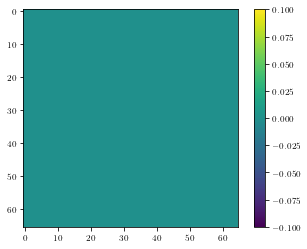

In [107]:
plt.figure(1, facecolor='w')
P.imshow(PBy[0,:,:])
P.colorbar()

N.max(Ex)

0.015797937354991843

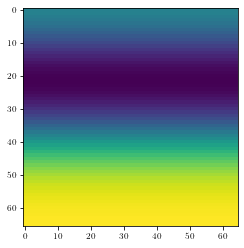

In [103]:
field = By[0, :, :]

plt.figure(1, facecolor='w')
plt.imshow(field)
N.max(N.abs(field))

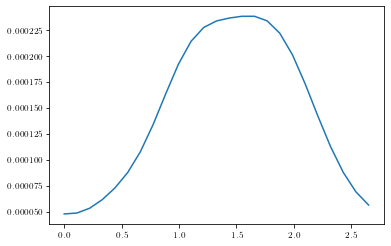

In [92]:
plt.figure(2, facecolor='w')
plt.plot(N.transpose(etot)[0],N.transpose(etot)[1])

In [93]:
ratio = 1.0

def plot_fields():

    fig = P.figure(1, figsize=(6,6), dpi=100, facecolor='w')
    ax = P.subplot(111)

    P.pcolormesh(xBz_grid - 0.5, yBz_grid - 0.5, Bz[0, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
    P.pcolormesh(xBz_grid + 0.5, yBz_grid - 0.5, Bz[1, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
    P.pcolormesh(xBz_grid - 0.5, yBz_grid + 0.5, Bz[2, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
    P.pcolormesh(xBz_grid + 0.5, yBz_grid + 0.5, Bz[3, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')

#     P.pcolormesh(xEy_grid - 0.5, yEy_grid - 0.5, Bx[0, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid + 0.5, yEy_grid - 0.5, Bx[1, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid - 0.5, yEy_grid + 0.5, Bx[2, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid + 0.5, yEy_grid + 0.5, Bx[3, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')

#     P.pcolormesh(xEx_grid - 0.5, yEx_grid - 0.5, By[0, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEx_grid + 0.5, yEx_grid - 0.5, By[1, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEx_grid - 0.5, yEx_grid + 0.5, By[2, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEx_grid + 0.5, yEx_grid + 0.5, By[3, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
    
#     P.pcolormesh(xEz_grid - 0.5, yEz_grid - 0.5, Ez[0, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEz_grid + 0.5, yEz_grid - 0.5, Ez[1, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEz_grid - 0.5, yEz_grid + 0.5, Ez[2, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEz_grid + 0.5, yEz_grid + 0.5, Ez[3, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
    
    
#     P.plot([0, 0],[-1.25, 1.25], color='k')
    
#     P.colorbar()
    
    P.ylim((y_min - 0.5, y_max + 0.5))
    P.xlim((x_min - 0.5, x_max + 0.5))
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    
    plt.axvline(x=0.0, c='black')
    plt.axhline(y=0.0, c='black')
    
    P.show()
